## 1. Imports

In [1]:
import torch
# Download an example image from the pytorch website
import urllib
from PIL import Image as Image 
from torchvision import transforms
from IPython.display import Image as show_img
import numpy as np
import pandas as pd
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import shap
import torchvision
import os
import cv2


## 2. Functions

In [2]:
def pre_process(lista, index):
    # remove directories
    lista = [item[index:] for item in lista]
    
    # remove digits
    lista = [re.sub(r'\b\d+\b', '', item) for item in lista]

    # remove hiffens 
    lista = [re.sub(r'\b-\b', ' ', item) for item in lista]

    # remove punctuation
    lista = [item.strip(string.punctuation) for item in lista]
    
    return lista

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

def convert_bars(lista):
    lista = [item.replace('\\', '/') for item in lista]
    return lista

def files_in_folder(path):
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.jpg' in file:
                files.append(os.path.join(r, file))
    files = convert_bars(files)
    return files

def predict(pill_transf, preprocess_transform, image):
    input_tensor = preprocess_transform(pill_transf(image))
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    predicted = torch.nn.functional.softmax(output[0], dim=0).argmax()
    scores = torch.nn.functional.softmax(output[0], dim=0)
    y_hat = pd.read_csv('labels.csv',index_col = 'id').loc[int(predicted)+1].label
    return y_hat, predicted, scores

def batch_predict_cuda(images):
    model.eval()
    model.to('cuda')
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    #batch =preprocess_transform(images).unsqueeze(0)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()
def batch_predict_cpu(images):
    model.eval()
    model.to('cpu')
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    #batch =preprocess_transform(images).unsqueeze(0)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def jaccard(im1, im2):
    """
    Computes the Jaccard metric, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    jaccard : float
        Jaccard metric returned is a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
    
    Notes
    -----
    The order of inputs for `jaccard` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    union = np.logical_or(im1, im2)

    return intersection.sum() / float(union.sum())

## 3. Load model

In [3]:
device = torch.device("cuda")
model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)
model.to(device)
model.eval()

Using cache found in C:\Users\fc/.cache\torch\hub\pytorch_vision_v0.4.2


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

## 4. Examples of the 5 best classifications

In [4]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [5]:
dataset = torchvision.datasets.ImageFolder('256_ObjectCategories')
class_names = pd.read_csv('labels.csv',index_col = 'id').label.to_list()

## 4.1. True label - harp; Predicted label - harp 

Prediction of MobileNet: hartebeest


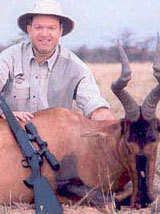

In [6]:
#filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/098.harp/098_0001.jpg"
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/173.rifle/173_0030.jpg"

input_image41 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image41)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

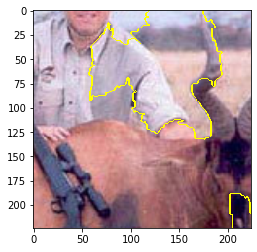

In [7]:
explainer = lime_image.LimeImageExplainer()
explanation41 = explainer.explain_instance(np.array(pill_transf(input_image41)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation41.get_image_and_mask(explanation41.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [8]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image41)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image41)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


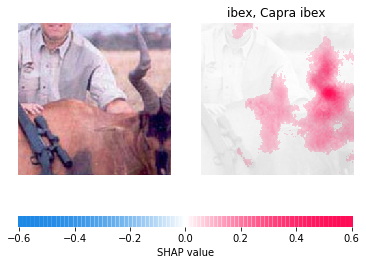

In [9]:
import cv2


resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [10]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.05      , 0.20500732])

## 5. Examples of the 5 worst classifications 

## 5.1. True label - canoe ; Predicted label - Thatch, thatches roof

Prediction of MobileNet: thatch, thatched roof


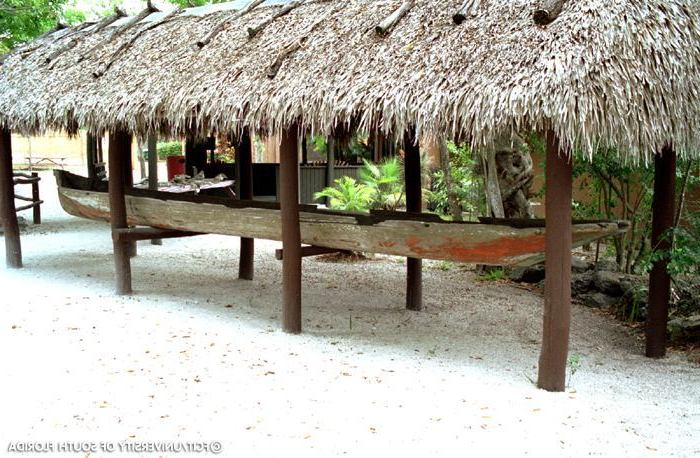

In [12]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/030.canoe/030_0086.jpg"
input_image51 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image51)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

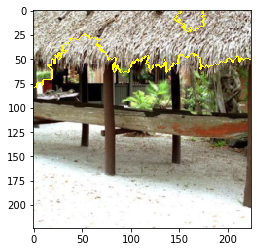

In [16]:
explainer = lime_image.LimeImageExplainer()
explanation51 = explainer.explain_instance(np.array(pill_transf(input_image51)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation51.get_image_and_mask(explanation51.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [18]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image51)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image51)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


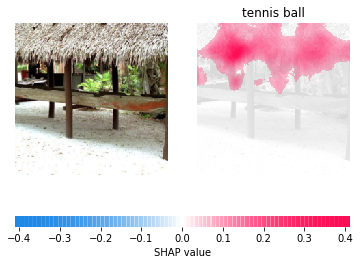

In [19]:


resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [20]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.10930931, 0.47908379])

## 5.2. True label - rifle ; Predicted label - hartbeest

Prediction of MobileNet: hartebeest


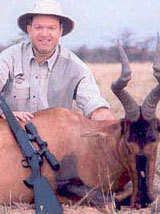

In [21]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/173.rifle/173_0030.jpg"
input_image52 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image52)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

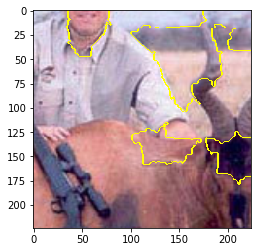

In [22]:
explainer = lime_image.LimeImageExplainer()
explanation52 = explainer.explain_instance(np.array(pill_transf(input_image52)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation52.get_image_and_mask(explanation52.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [23]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image52)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image52)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


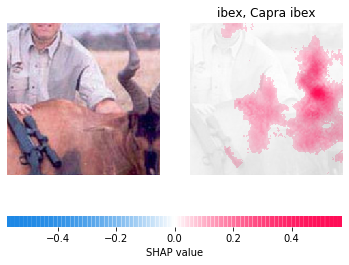

In [24]:
import cv2


resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [25]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.05      , 0.23432332])

## 5.3. True label - hummingbird ; Predicted label - little blue heron, egretta caerulea

Prediction of MobileNet: little blue heron, Egretta caerulea


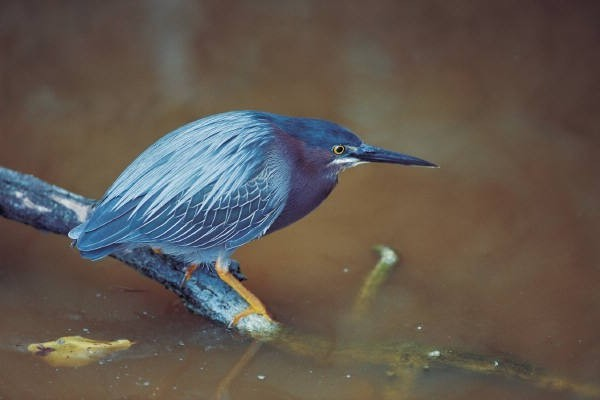

In [26]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/113.hummingbird/113_0080.jpg"
input_image53 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image53)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

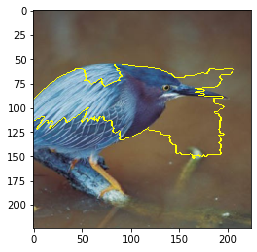

In [27]:
explainer = lime_image.LimeImageExplainer()
explanation53 = explainer.explain_instance(np.array(pill_transf(input_image53)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation53.get_image_and_mask(explanation53.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [28]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image53)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image53)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


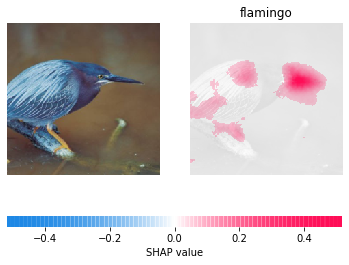

In [29]:
import cv2


resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [30]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.05      , 0.40519008])

## 5.4. True label - Mushroom ; Predicted label - coho, choe, coho salmon, blue jack, silver salmon, onchorhynchus kisutch

Prediction of MobileNet: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch


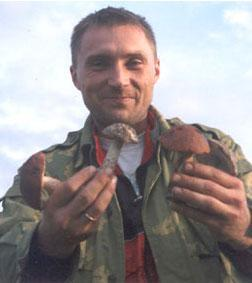

In [31]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/147.mushroom/147_0064.jpg"
input_image54 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image54)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

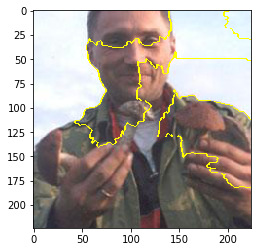

In [32]:
explainer = lime_image.LimeImageExplainer()
explanation54 = explainer.explain_instance(np.array(pill_transf(input_image54)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation54.get_image_and_mask(explanation54.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [33]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image54)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image54)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


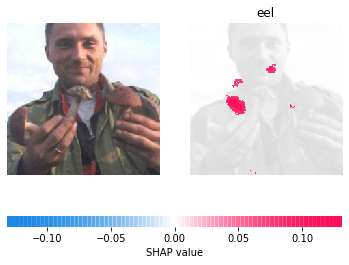

In [34]:
import cv2


resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [35]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.05      , 0.14078048])

## 5.5. True label - soccer ball ; Predicted label - ocarina, sweet potato

Prediction of MobileNet: ocarina, sweet potato


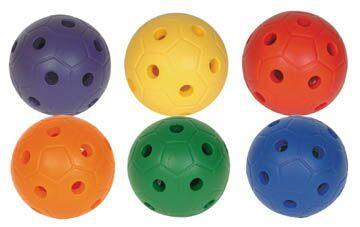

In [36]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/193.soccer-ball/193_0094.jpg"
input_image55 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image55)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

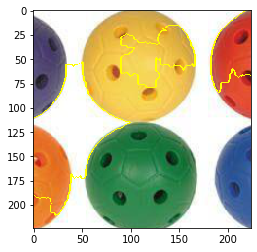

In [37]:
explainer = lime_image.LimeImageExplainer()
explanation55 = explainer.explain_instance(np.array(pill_transf(input_image55)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation55.get_image_and_mask(explanation55.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [38]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image55)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image55)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


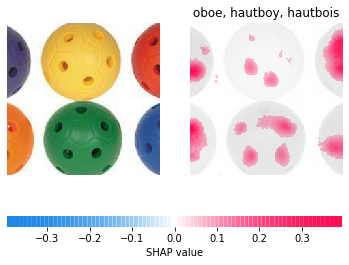

In [39]:
import cv2


resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [40]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.05      , 0.21112462])

# NEW TOPS


## 1.canhao 

Prediction of MobileNet: cannon


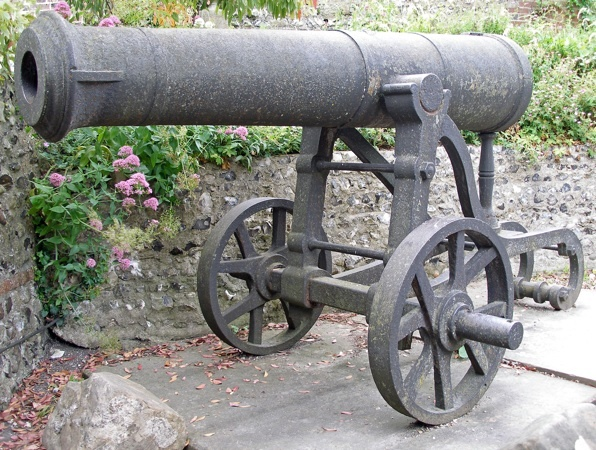

In [41]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/029.cannon/029_0033.jpg"
input_image61 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image61)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

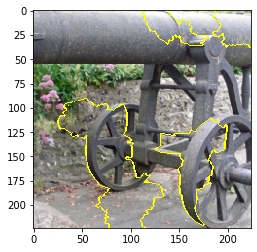

In [42]:
explainer = lime_image.LimeImageExplainer()
explanation61 = explainer.explain_instance(np.array(pill_transf(input_image61)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation61.get_image_and_mask(explanation61.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [43]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image61)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image61)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


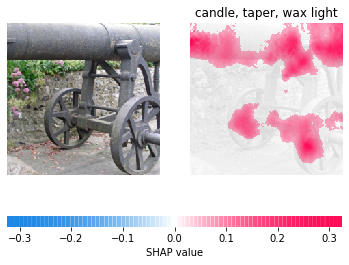

In [44]:
resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [45]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.054004  , 0.25125973])

# 2. centipede

Prediction of MobileNet: centipede


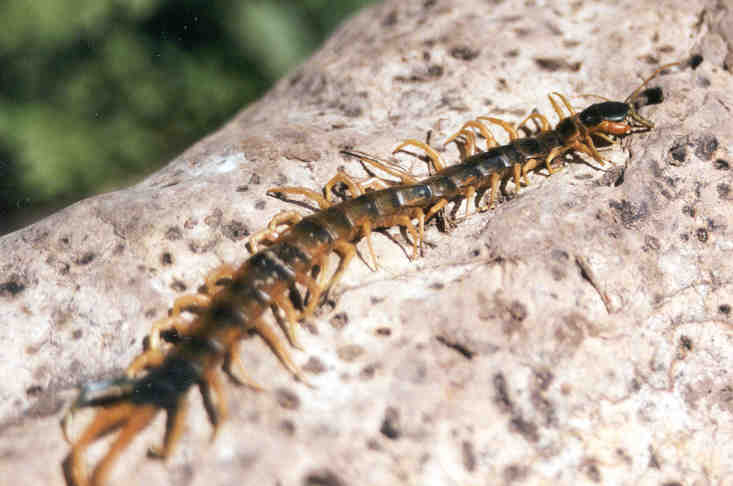

In [46]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/034.centipede/034_0036.jpg"
input_image62 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image62)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

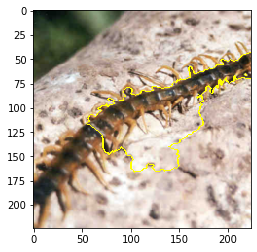

In [47]:
explainer = lime_image.LimeImageExplainer()
explanation62 = explainer.explain_instance(np.array(pill_transf(input_image62)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation62.get_image_and_mask(explanation62.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [48]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image62)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image62)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


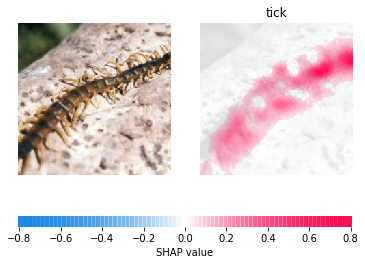

In [49]:
resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [50]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.11606607, 0.37099444])

# 3.golf ball

Prediction of MobileNet: golf ball


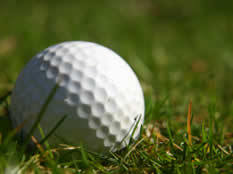

In [51]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/088.golf-ball/088_0092.jpg"
input_image63 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image63)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

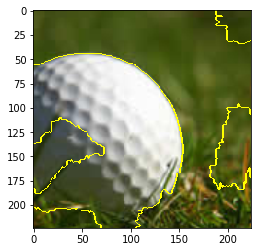

In [52]:
explainer = lime_image.LimeImageExplainer()
explanation63 = explainer.explain_instance(np.array(pill_transf(input_image63)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation63.get_image_and_mask(explanation63.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [53]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image63)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image63)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


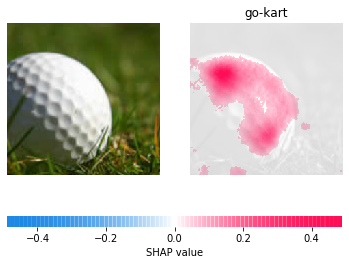

In [54]:
resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [55]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.05525526, 0.58203509])

# 4. football helmet

Prediction of MobileNet: football helmet


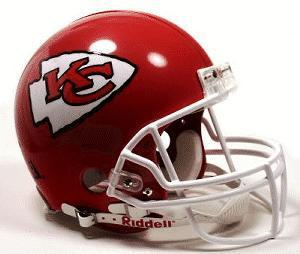

In [56]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/076.football-helmet/076_0045.jpg"
input_image64 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image64)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

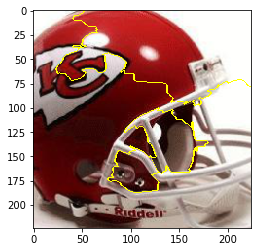

In [57]:
explainer = lime_image.LimeImageExplainer()
explanation64 = explainer.explain_instance(np.array(pill_transf(input_image64)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation64.get_image_and_mask(explanation64.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [58]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image64)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image64)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


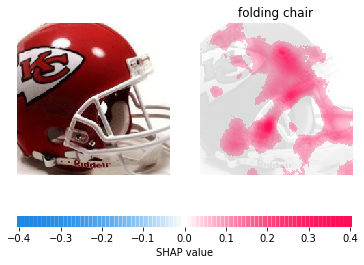

In [59]:
resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [60]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.05     , 0.2621063])

# 5. canhao

Prediction of MobileNet: cannon


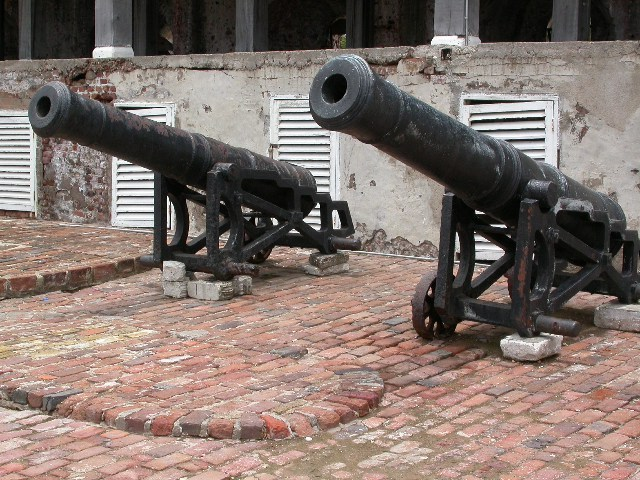

In [61]:
filename = "C:/Users/fc/OneDrive/IST/5 Ano/DSL/project/256_ObjectCategories/029.cannon/029_0084.jpg"
input_image65 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image65)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

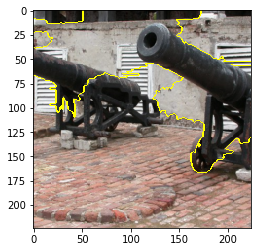

In [62]:
explainer = lime_image.LimeImageExplainer()
explanation65 = explainer.explain_instance(np.array(pill_transf(input_image65)), 
                                         batch_predict_cpu, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation65.get_image_and_mask(explanation65.top_labels[0], positive_only=True, num_features=7, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [63]:
background = []
rand_idxs = np.random.choice(len(dataset),50)
for i in rand_idxs:
    t = torchvision.transforms.functional.to_tensor(pill_transf(dataset[i][0]))
    background.append(t)

model.to(device)
background = torch.stack(background).to(device)
x_test = preprocess_transform(pill_transf(input_image65)).unsqueeze(0).to(device)

shap_numpy_layers = []
for i in range(len(model.features)):
    print(f"LAYER NR: {i}")
    e = shap.GradientExplainer((model, model.features[i]), background)
    shap_values,indexes = e.shap_values(x_test, ranked_outputs=1, nsamples=200)

    # get the names for the classes
    index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu())


    # plot the explanations
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap_numpy_layers.append(shap_numpy)
    test_numpy = np.swapaxes(np.swapaxes(torchvision.transforms.functional.to_tensor(pill_transf(input_image65)).unsqueeze(0).cpu().numpy(), 1, -1), 1, 2)
    #shap.image_plot(shap_numpy, test_numpy, index_names)

LAYER NR: 0
LAYER NR: 1
LAYER NR: 2
LAYER NR: 3
LAYER NR: 4
LAYER NR: 5
LAYER NR: 6
LAYER NR: 7
LAYER NR: 8
LAYER NR: 9
LAYER NR: 10
LAYER NR: 11
LAYER NR: 12
LAYER NR: 13
LAYER NR: 14
LAYER NR: 15
LAYER NR: 16
LAYER NR: 17
LAYER NR: 18


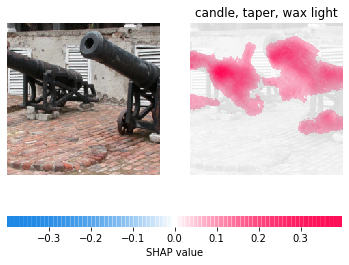

In [64]:
resized = []
for i in range(len(shap_numpy_layers)):
    curr_img_array = np.array(shap_numpy_layers[i][0]).sum(-1)
    resized_vec = []
    for img in curr_img_array:
        res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        resized_vec.append(res)
    resized.append(resized_vec)
shap.image_plot([np.array(resized).mean(0)*(np.array(resized).mean(0)>0.10)], test_numpy, index_names,width=50, aspect=0.2, hspace=0.2)

In [65]:
jacc_record = []
for i,k in enumerate(np.linspace(0.05,0.3,1000)):
    jacc_record.append((k,jaccard((np.array(resized).mean(0)>k).squeeze(0),mask)))
jacc_record = np.array(jacc_record)
jacc_record[np.argmax(jacc_record[:,1])]

array([0.05      , 0.42689561])